### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Fri Oct 31 07:07:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 67.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 129.5 MB/s eta 0:00:00


## Download dataset from Roboflow Universe

In [10]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="uk68aw2zaA1ZAoPSVYNF")
project = rf.workspace("dandata").project("security_surveillance")
version = project.version(1)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Security_Surveillance-1 in yolov12:: 100%|██████████| 10924/10924 [00:02<00:00, 5322.95it/s]


In [11]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [12]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [13]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 11
names: ['-', 'Creeping', '\', 'crawling', 'crawling_with_weapon', 'crouching', 'crouching_with_weapon', 'cycling', 'motor_bike', 'walking', 'walking_with_weapon']

roboflow:
  workspace: dandata
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [15]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=70)

New https://pypi.org/project/ultralytics/8.3.223 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/Security_Surveillance-1/data.yaml, epochs=70, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho

train: Scanning /content/Security_Surveillance-1/train/labels.cache... 4914 images, 30 backgrounds, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Security_Surveillance-1/valid/labels.cache... 303 images, 6 backgrounds, 0 corrupt: 100%|██████████| 303/303 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      6.87G      3.923      4.736      3.716         17        640: 100%|██████████| 308/308 [02:55<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]

                   all        303        949     0.0333     0.0847     0.0165    0.00381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      7.19G      2.774      3.176      2.617         13        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]

                   all        303        949      0.163      0.261      0.114     0.0383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      7.06G       2.43      2.822      2.298         24        640: 100%|██████████| 308/308 [02:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        303        949      0.188        0.3      0.147      0.057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70       7.2G      2.266      2.657      2.142         13        640: 100%|██████████| 308/308 [02:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]

                   all        303        949      0.212       0.34      0.181     0.0834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      7.23G      2.157      2.553      2.043         17        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        303        949      0.287      0.406      0.226     0.0994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      7.23G      2.063      2.454      1.961         18        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        303        949      0.224      0.371      0.194     0.0958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70       7.2G      2.005      2.376      1.919         17        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

                   all        303        949      0.238      0.402      0.234      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      7.21G      1.953      2.317      1.872         19        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]

                   all        303        949      0.261      0.387      0.248      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70       7.2G      1.908      2.259      1.831         27        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]

                   all        303        949      0.295      0.332      0.237      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70       7.2G       1.87      2.218      1.797         17        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]

                   all        303        949      0.308      0.447      0.312      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      7.23G      1.834       2.17      1.763         17        640: 100%|██████████| 308/308 [02:41<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]

                   all        303        949      0.354      0.379      0.306      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      7.24G      1.798      2.129      1.725         21        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]

                   all        303        949      0.331      0.511       0.34      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      7.23G      1.775      2.105      1.698          3        640: 100%|██████████| 308/308 [02:41<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

                   all        303        949      0.332      0.463      0.318      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70       7.2G      1.746      2.069      1.674         12        640: 100%|██████████| 308/308 [02:41<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

                   all        303        949      0.324      0.494      0.344      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      7.19G      1.713       2.02      1.639         22        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

                   all        303        949      0.341      0.547      0.363      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      7.21G      1.701      2.009      1.626         14        640: 100%|██████████| 308/308 [02:41<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]

                   all        303        949      0.359      0.495      0.355      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      7.23G      1.673      1.982       1.61         26        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]

                   all        303        949      0.342      0.532      0.359      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      7.23G      1.647      1.933      1.585         25        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]

                   all        303        949      0.346        0.5      0.355      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70       7.2G       1.63      1.926      1.572         15        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]

                   all        303        949      0.387      0.572      0.424      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70       7.2G      1.608      1.895      1.557          6        640: 100%|██████████| 308/308 [02:41<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]

                   all        303        949      0.427      0.526      0.411      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70       7.2G      1.588      1.866      1.529          7        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

                   all        303        949      0.419      0.508      0.428      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      7.19G      1.579      1.853      1.523          6        640: 100%|██████████| 308/308 [02:41<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        303        949      0.399       0.58      0.452       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70       7.2G      1.559       1.83      1.507         16        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]

                   all        303        949      0.393      0.551      0.437      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70       7.2G      1.554      1.805      1.499         26        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]

                   all        303        949      0.412      0.491      0.437      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      7.23G      1.541      1.787      1.491         18        640: 100%|██████████| 308/308 [02:41<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]

                   all        303        949      0.429      0.537      0.451      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70       7.2G      1.526      1.755       1.48          5        640: 100%|██████████| 308/308 [02:41<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]

                   all        303        949      0.432      0.553       0.48       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      7.23G      1.514       1.75       1.47         12        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]

                   all        303        949      0.425      0.613      0.473       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      7.24G      1.496      1.721      1.445         18        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]

                   all        303        949      0.459      0.641      0.514      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70       7.2G       1.49      1.705      1.444         14        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

                   all        303        949       0.42      0.615      0.475      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70       7.2G       1.48      1.695      1.441         10        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]

                   all        303        949      0.451       0.62      0.512      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70       7.2G       1.47       1.67      1.428         13        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]

                   all        303        949      0.461      0.612      0.516      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      7.21G       1.45      1.647      1.416          9        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

                   all        303        949      0.463      0.608      0.525      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      7.23G      1.448       1.65      1.417          9        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]

                   all        303        949      0.479      0.687      0.552       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      7.23G      1.442       1.63      1.407         29        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]

                   all        303        949      0.488      0.648      0.564      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70       7.2G      1.435      1.609      1.395         30        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]

                   all        303        949      0.447      0.666      0.544      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      7.23G      1.428      1.594      1.394         13        640: 100%|██████████| 308/308 [02:41<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

                   all        303        949      0.496      0.668      0.582      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      7.24G      1.406      1.566      1.375         11        640: 100%|██████████| 308/308 [02:41<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        303        949      0.515       0.66      0.601      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      7.21G      1.409      1.571      1.377         14        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]

                   all        303        949      0.506      0.691      0.609      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70       7.2G      1.397      1.551      1.364         21        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]

                   all        303        949      0.503      0.703      0.625       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70       7.2G      1.382      1.538      1.362         25        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]

                   all        303        949      0.533      0.681      0.649      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      7.19G      1.384      1.528      1.361          9        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]

                   all        303        949      0.541      0.691      0.623      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      7.23G      1.377      1.506      1.352         21        640: 100%|██████████| 308/308 [02:41<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

                   all        303        949      0.545      0.655      0.652      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      7.24G      1.358      1.497      1.339         16        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

                   all        303        949      0.563      0.659      0.655      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70       7.2G      1.357      1.472      1.333         19        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]

                   all        303        949      0.581      0.665      0.647      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70       7.2G      1.347      1.466       1.33          7        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]

                   all        303        949      0.617      0.659      0.686      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      7.23G      1.343      1.442      1.324         12        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

                   all        303        949      0.659       0.67      0.695      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      7.19G      1.338      1.431       1.32         10        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]

                   all        303        949      0.628      0.672      0.679      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70       7.2G      1.322      1.419      1.313         16        640: 100%|██████████| 308/308 [02:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

                   all        303        949      0.625      0.674      0.697       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70       7.2G      1.322      1.417      1.312         29        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        303        949       0.62      0.676      0.701       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      7.23G      1.317      1.406      1.308         13        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

                   all        303        949      0.636      0.679      0.708      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      7.19G      1.313      1.387      1.304         14        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

                   all        303        949      0.659      0.692      0.732      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70       7.2G      1.291       1.37      1.289         14        640: 100%|██████████| 308/308 [02:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]

                   all        303        949      0.652      0.659      0.713      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      7.19G      1.297      1.361      1.292         12        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]

                   all        303        949      0.684      0.661      0.721      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      7.22G      1.292      1.353      1.289          8        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

                   all        303        949      0.684      0.678      0.728       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70       7.2G      1.283       1.33      1.281         16        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]

                   all        303        949      0.686       0.69      0.741      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      7.23G      1.279      1.329      1.277          4        640: 100%|██████████| 308/308 [02:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]

                   all        303        949      0.712      0.691      0.756       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70       7.2G      1.275      1.317      1.277         25        640: 100%|██████████| 308/308 [02:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]

                   all        303        949      0.695       0.71      0.763      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70       7.2G      1.268      1.303       1.27         20        640: 100%|██████████| 308/308 [02:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

                   all        303        949      0.679      0.702      0.743      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      7.22G      1.264      1.296      1.267         23        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]

                   all        303        949      0.687      0.692      0.754      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      7.22G      1.249       1.28      1.258          8        640: 100%|██████████| 308/308 [02:42<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]

                   all        303        949      0.715      0.684      0.754      0.558


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      7.19G      1.197      1.202      1.257         10        640: 100%|██████████| 308/308 [02:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

                   all        303        949      0.723       0.71      0.767      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      7.19G      1.174      1.167      1.247          4        640: 100%|██████████| 308/308 [02:41<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        303        949      0.731      0.714       0.79      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      7.22G      1.176       1.16      1.245          6        640: 100%|██████████| 308/308 [02:41<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

                   all        303        949       0.72      0.729      0.789      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      7.19G      1.166      1.141      1.237          3        640: 100%|██████████| 308/308 [02:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        303        949      0.697      0.749       0.79      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70       7.2G      1.163      1.138      1.234          7        640: 100%|██████████| 308/308 [02:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

                   all        303        949      0.692      0.754      0.795      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      7.19G      1.154      1.114      1.228         12        640: 100%|██████████| 308/308 [02:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]

                   all        303        949      0.723      0.732      0.794      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      7.18G      1.155      1.118      1.232         13        640: 100%|██████████| 308/308 [02:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]

                   all        303        949      0.694      0.759      0.798      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70       7.2G      1.142      1.102      1.223          9        640: 100%|██████████| 308/308 [02:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

                   all        303        949      0.709      0.756      0.804      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70       7.2G      1.139      1.093      1.217          4        640: 100%|██████████| 308/308 [02:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

                   all        303        949      0.703      0.756      0.802        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      7.19G      1.141      1.093      1.223          8        640: 100%|██████████| 308/308 [02:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

                   all        303        949      0.737       0.73      0.806        0.6



70 epochs completed in 3.263 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 18.6MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,078,465 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


                   all        303        949      0.737       0.73      0.806        0.6
              crawling        136        188      0.734      0.803      0.831      0.632
  crawling_with_weapon        108        147      0.724      0.822      0.845      0.665
             crouching        104        130      0.806      0.654       0.84      0.649
 crouching_with_weapon         99        146      0.775      0.863      0.877      0.705
               walking         94        122      0.637      0.508      0.605      0.377
   walking_with_weapon        128        216      0.749      0.731      0.838      0.574
Speed: 0.2ms preprocess, 9.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/train2


## Evaluate fine-tuned YOLOv12 model

In [16]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   train_batch1.jpg
events.out.tfevents.1761894751.326592c93b82.302.0  train_batch2.jpg
train_batch0.jpg				   weights


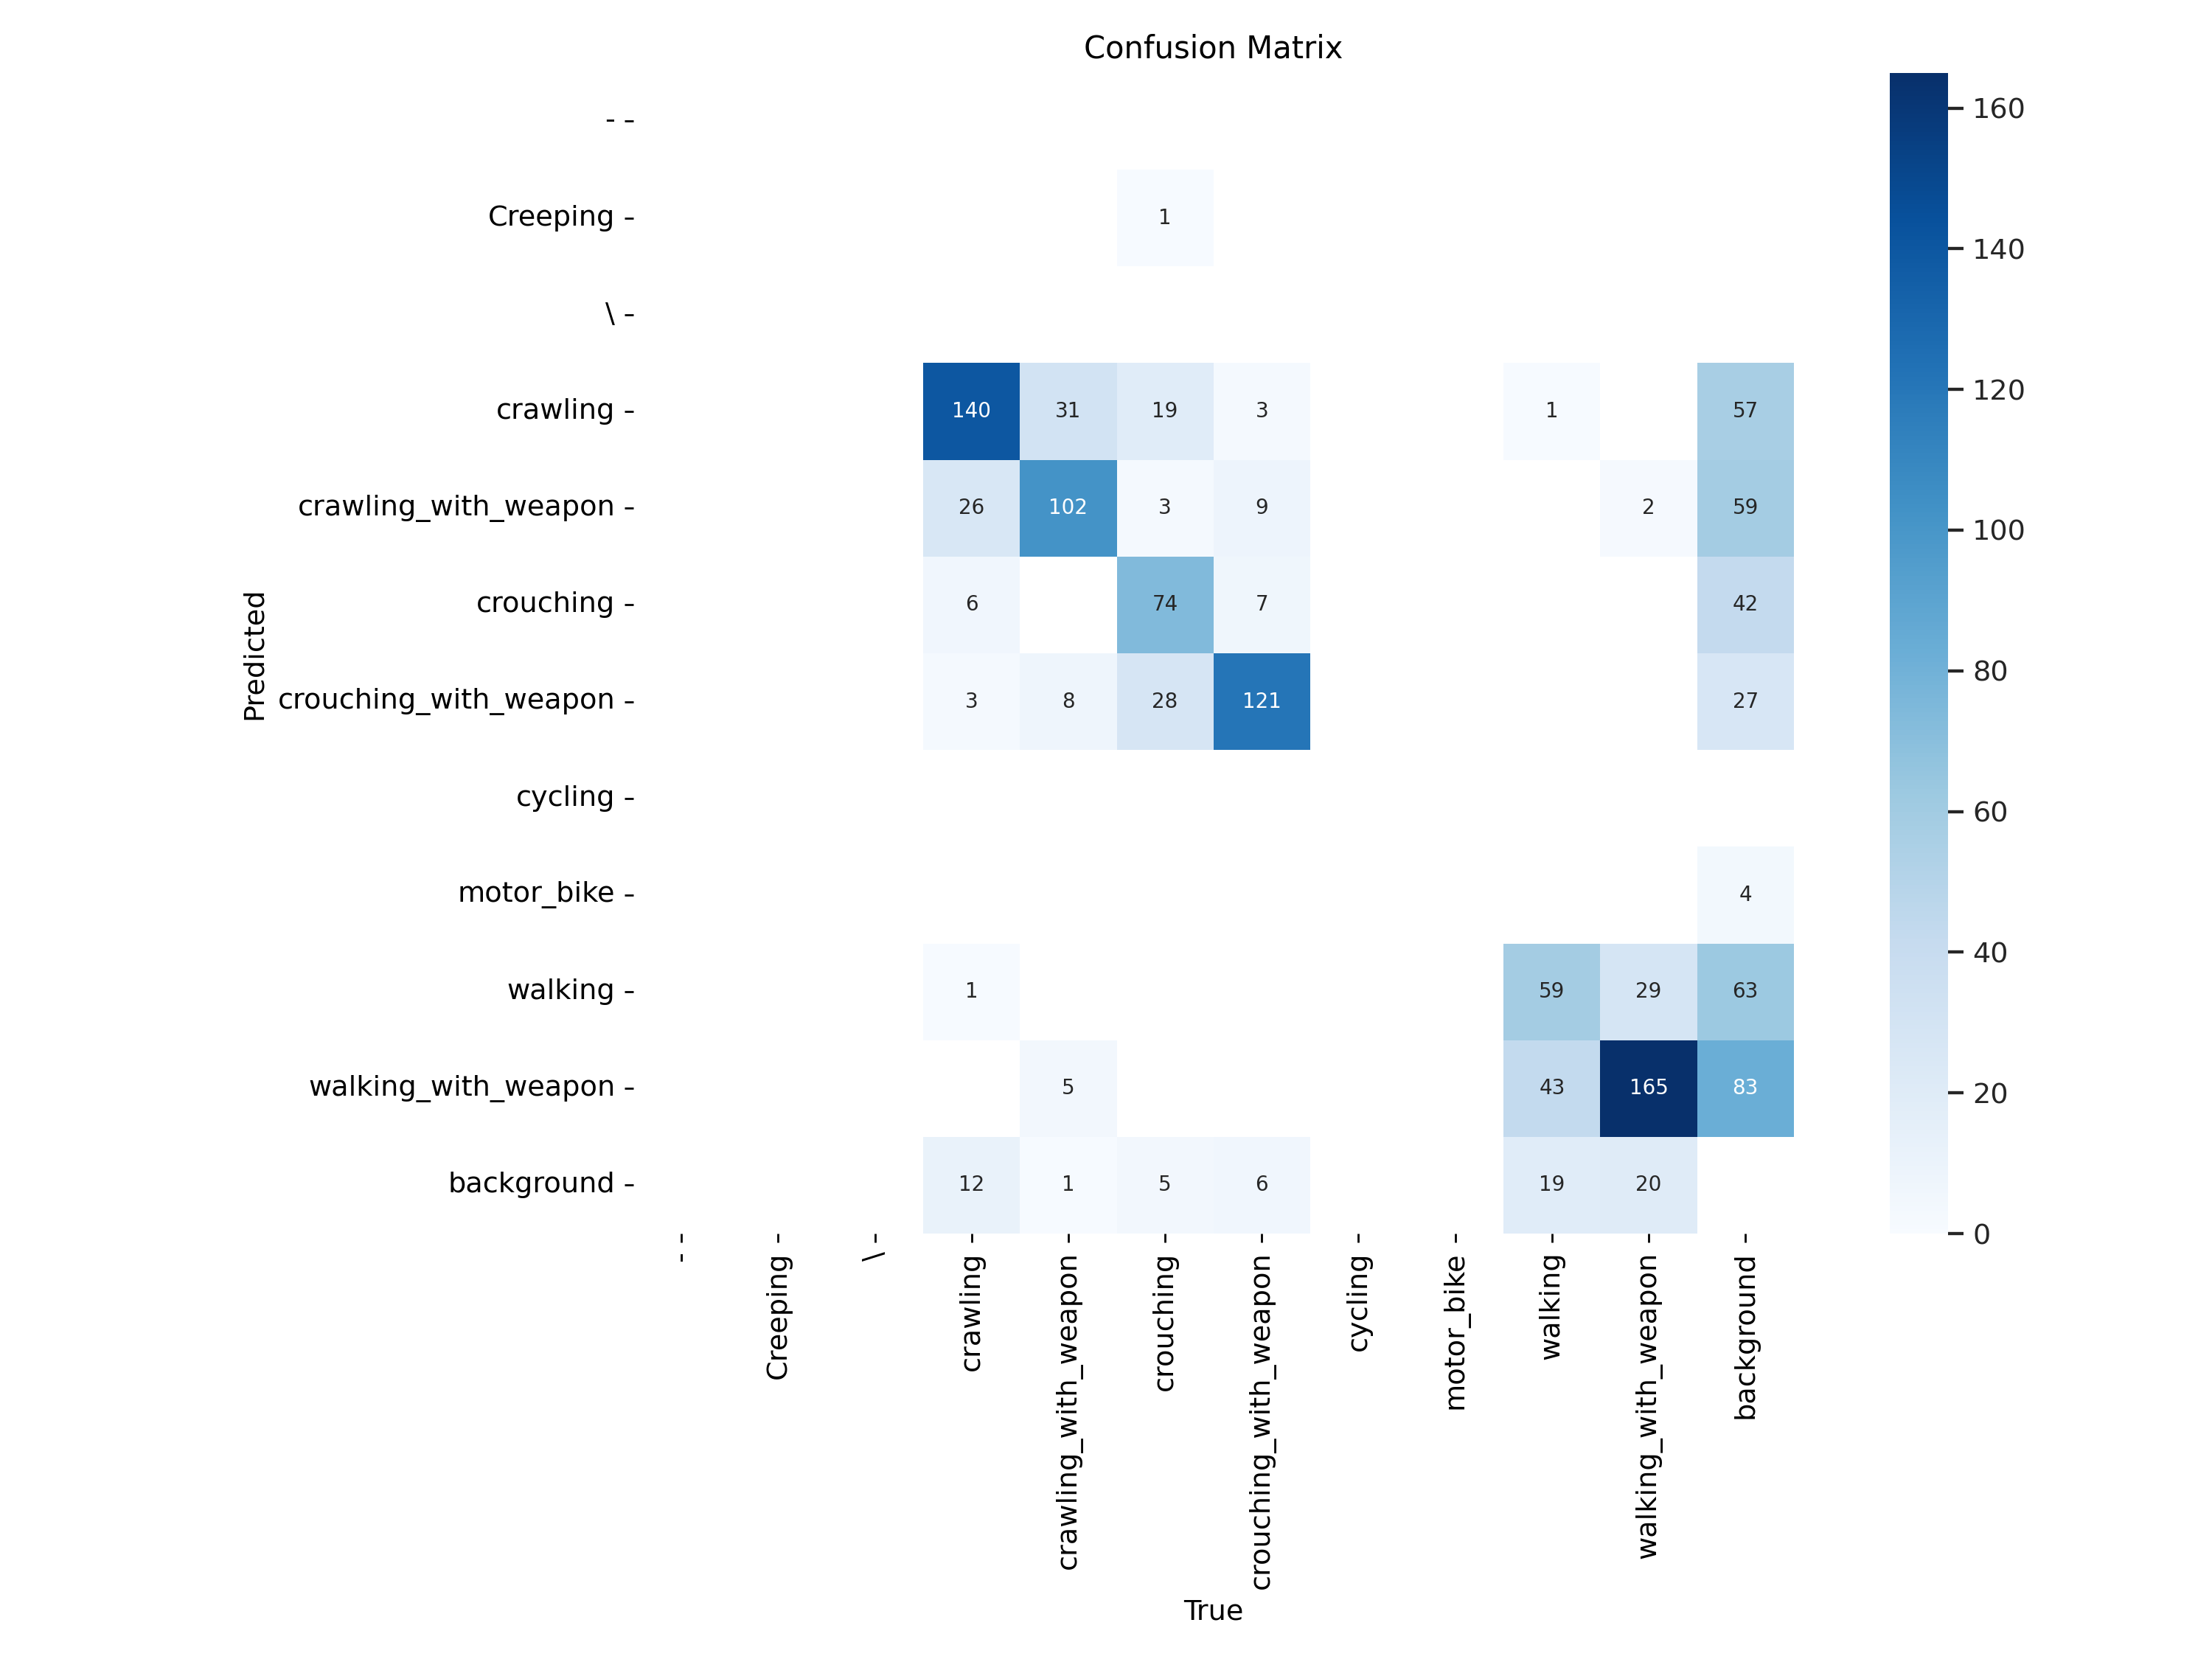

In [17]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=1000)

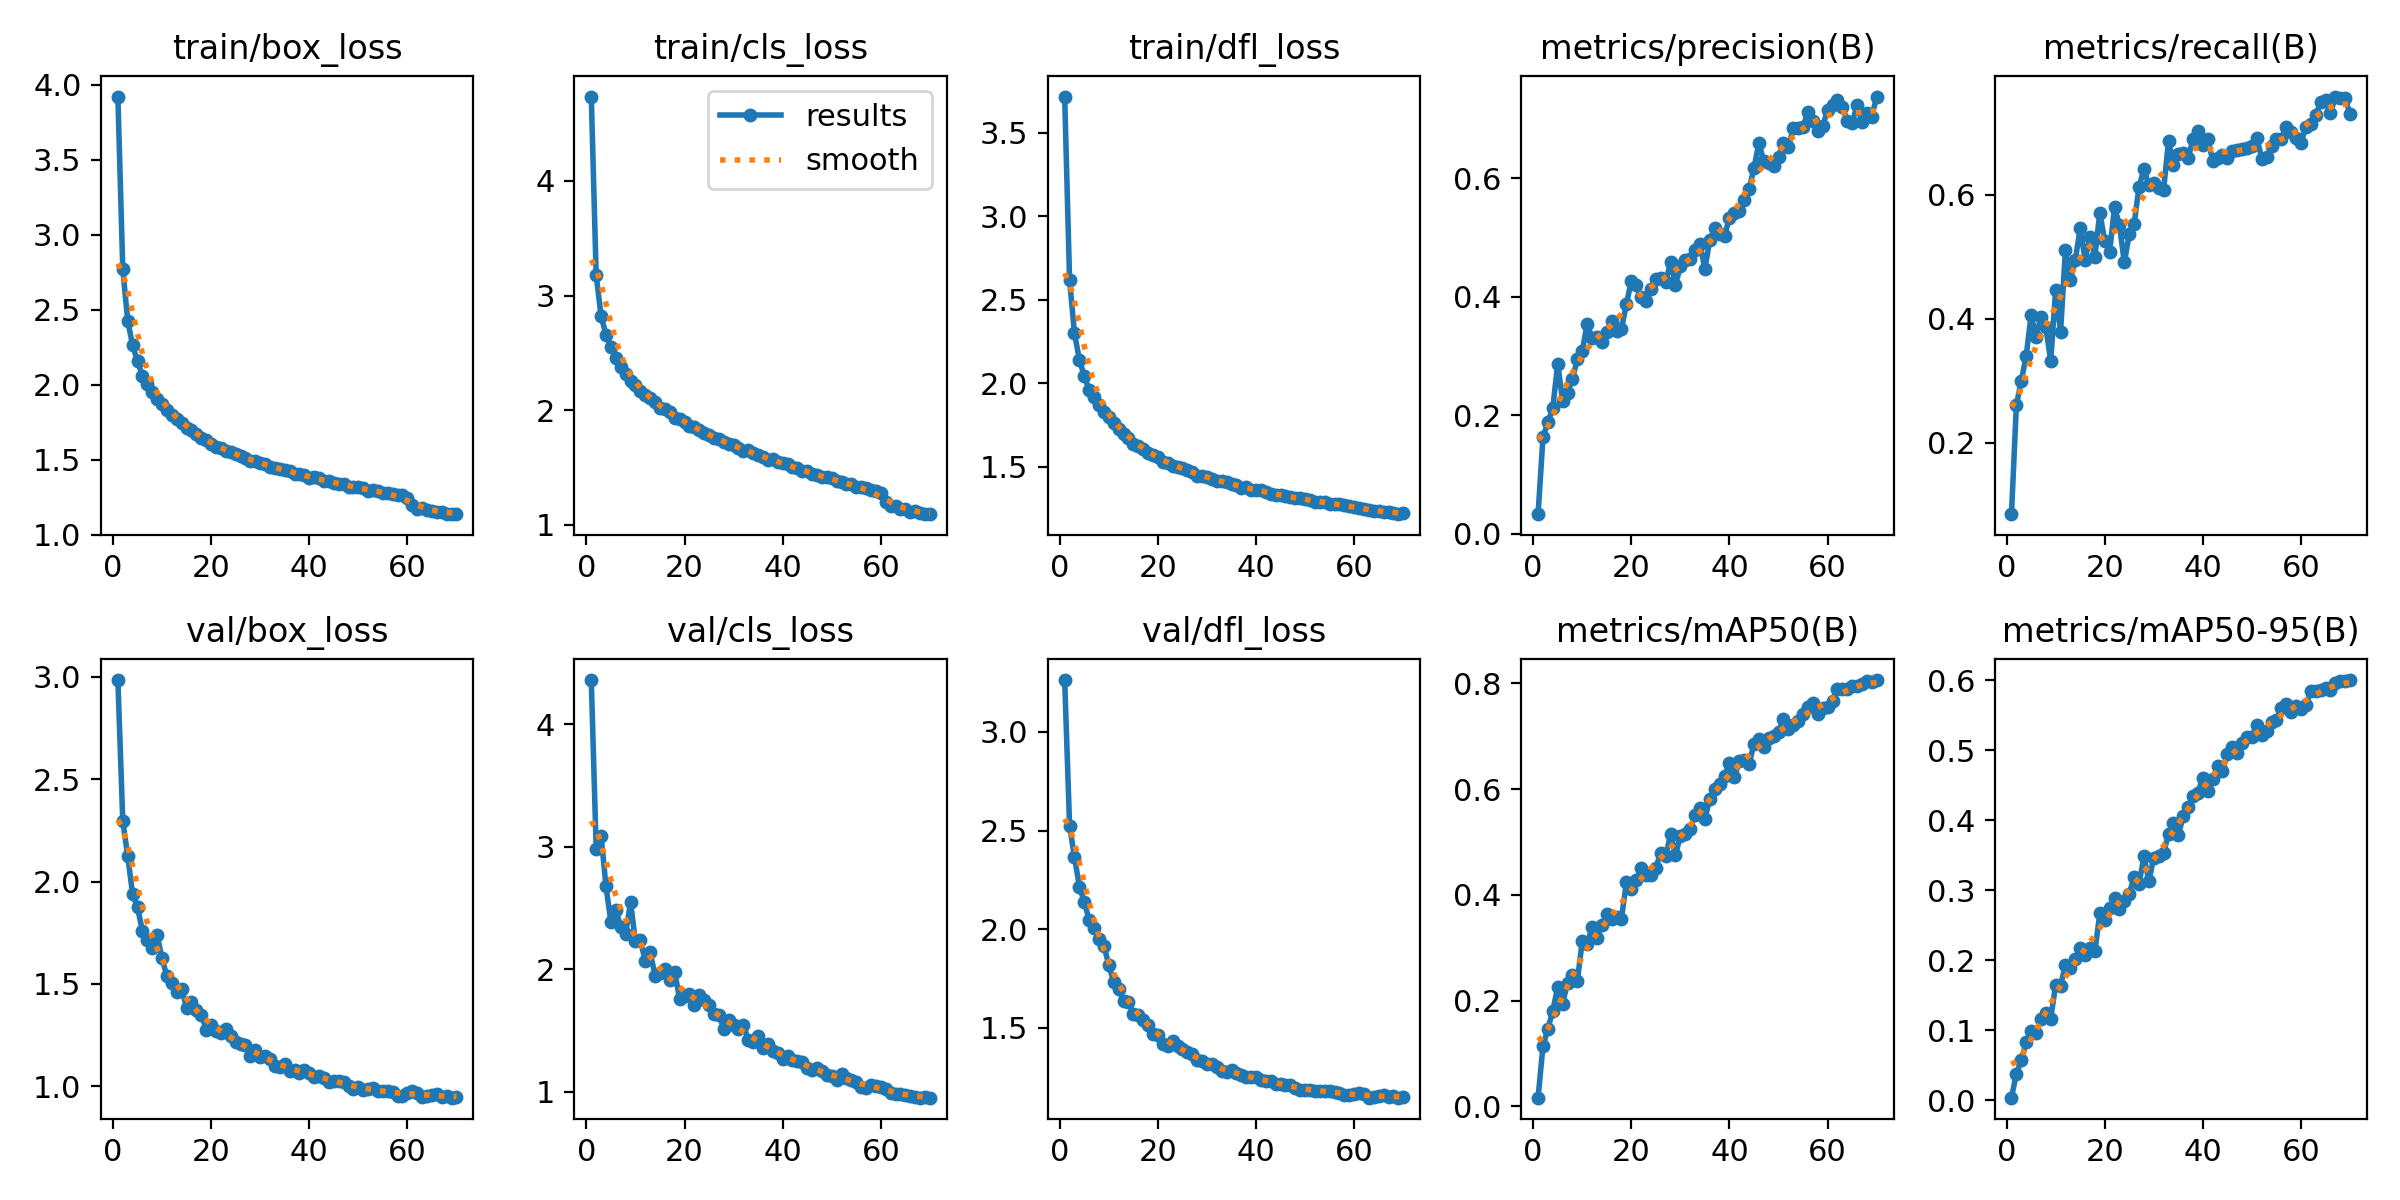

In [19]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/results.png', width=1000)

In [20]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['-',
 'Creeping',
 '\\',
 'crawling',
 'crawling_with_weapon',
 'crouching',
 'crouching_with_weapon',
 'cycling',
 'motor_bike',
 'walking',
 'walking_with_weapon']

In [23]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train2/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [24]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.5275913199372414
mAP 50 0.6872265284173613
mAP 75 0.6275575585796421


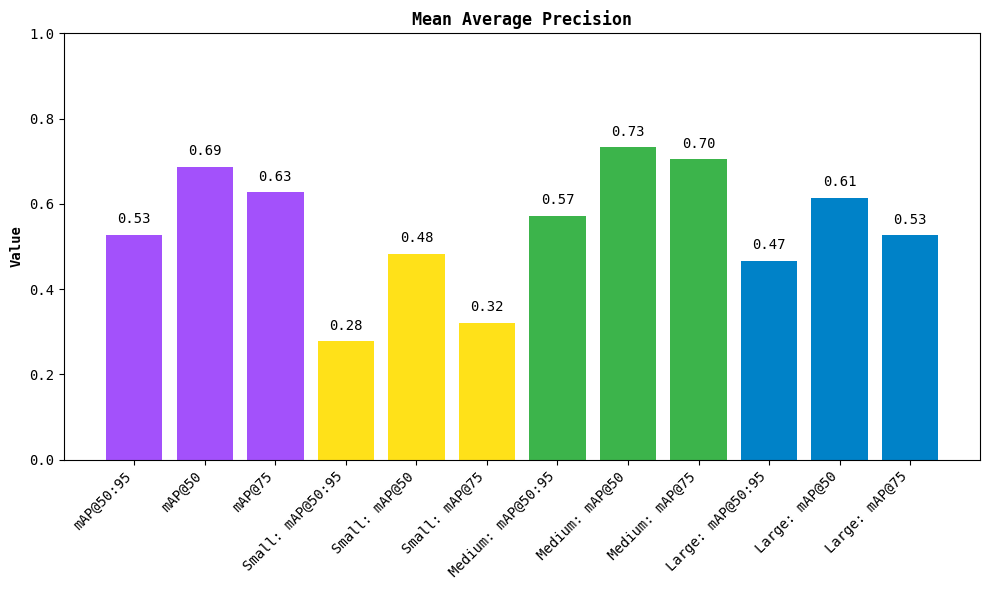

In [25]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [27]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train2/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

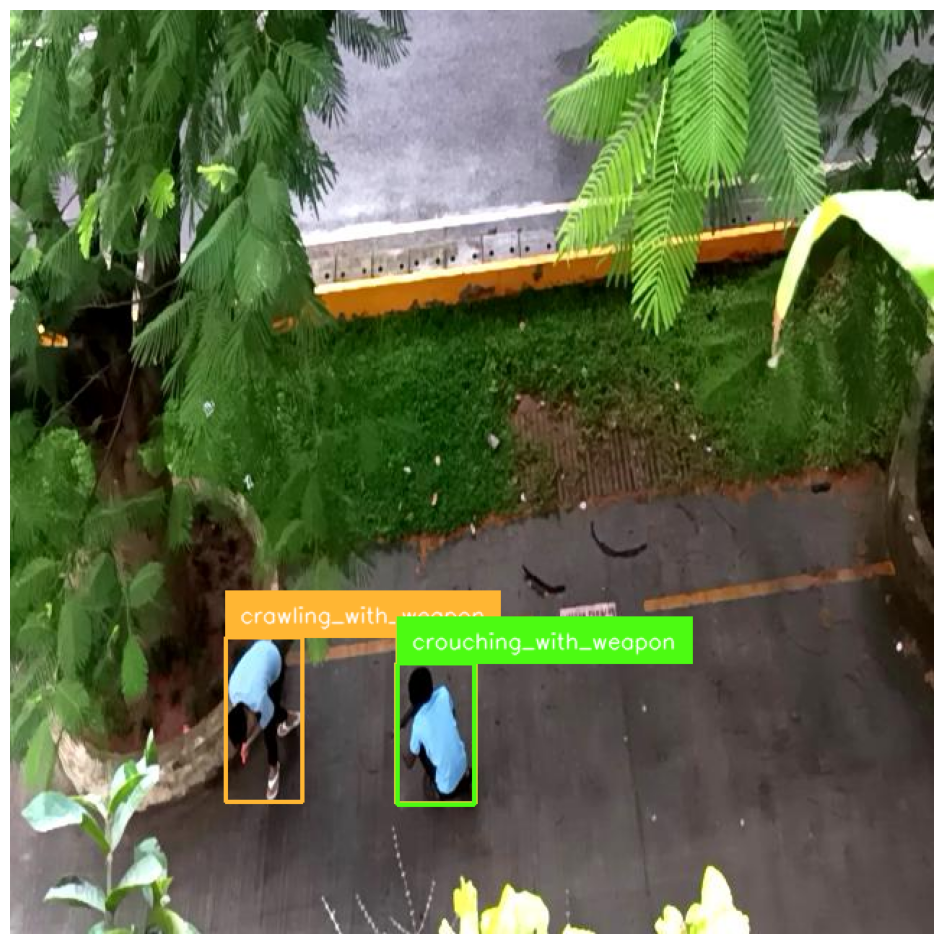

In [38]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)